In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
load_dotenv()

True

In [26]:
class FeedbackSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback on the essay")
    score: int = Field(description="Score on the essay from 1 to 10", ge=0, le=10)

In [36]:
model = ChatOpenAI()
model_with_structured_output = model.with_structured_output(FeedbackSchema)

D:\Data Science\My Projects\Langgraph Tutorials\venv\lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [44]:
class EssayState(TypedDict):
    essay: str

    language_feedback: str
    depth_feedback: str
    clarity_feedback: str
    overall_feedback: str

    individual_score: Annotated[list[int], operator.add]
    avg_score: float

In [52]:
def eval_language(state: EssayState):
    prompt = f"""Evaluate the following essay on language and provide feedback and a score from 1 to 10:\n\n{state["essay"]}"""
    response = model_with_structured_output.invoke(prompt)

    return {"language_feedback": response.feedback,
            "individual_score": [response.score]}

In [53]:
def eval_depth(state: EssayState):
    prompt = f"""Evaluate the following essay on depth of analysis and provide feedback and a score from 1 to 10:\n\n{state["essay"]}"""
    response = model_with_structured_output.invoke(prompt)

    return {"depth_feedback": response.feedback,
            "individual_score": [response.score]}

In [54]:
def eval_clarity(state: EssayState):
    prompt = f"""Evaluate the following essay on clarity of thoughts and provide feedback and a score from 1 to 10:\n\n{state["essay"]}"""
    response = model_with_structured_output.invoke(prompt)

    return {"clarity_feedback": response.feedback,
            "individual_score": [response.score]}

In [59]:
def final_eval(state: EssayState):
    prompt = """Create a summary of feedback based on state["language_feedback"], state["depth_feedback"] and state["clarity_feedback"]"""
    response = model.invoke(prompt).content

    avg_score = sum(state["individual_score"]) / len(state["individual_score"])

    return {"overall_feedback": response,
            "avg_score": avg_score}

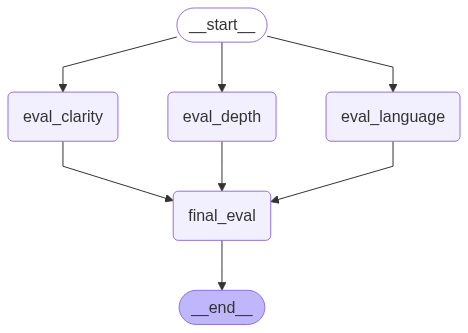

In [60]:
graph = StateGraph(EssayState)

graph.add_node("eval_language", eval_language)
graph.add_node("eval_depth", eval_depth)
graph.add_node("eval_clarity", eval_clarity)
graph.add_node("final_eval", final_eval)

graph.add_edge(START, "eval_language")
graph.add_edge(START, "eval_depth")
graph.add_edge(START, "eval_clarity")

graph.add_edge("eval_language", "final_eval")
graph.add_edge("eval_depth", "final_eval")
graph.add_edge("eval_clarity", "final_eval")

graph.add_edge("final_eval", END)

workflow = graph.compile()
workflow

In [61]:
essay = """
As artificial intelligence reshapes our societies, economies, and daily lives, it also prompts profound ethical, philosophical, and existential questions. In this rapidly changing landscape, religion continues to play an important role in offering moral guidance, preserving human dignity, and shaping our collective conscience.

One of the most significant concerns in the age of AI is the potential erosion of human values in favor of efficiency and automation. Here, religion can serve as a moral compass. Most religious traditions emphasize compassion, accountability, justice, and the sanctity of life—principles that can help guide the development and deployment of AI technologies. For instance, questions around the ethical use of surveillance, the fairness of algorithmic decisions, and the autonomy of AI systems are not just technical issues—they are moral ones, and religion offers a framework to address them.

Additionally, as AI challenges traditional views on consciousness and personhood, religion offers centuries of thought on the nature of the soul, identity, and human purpose. While science can explain how AI systems work, it is religion that helps us ask why we are building them, and what kind of world we hope to create.

Religion also has a role in fostering dialogue across cultures in a global AI age. As different societies develop and use AI in different ways, interfaith and ethical discussions can help create shared values and responsibilities, ensuring that AI benefits humanity as a whole and not just a few.

In conclusion, religion does not stand in opposition to technology. Rather, in the age of AI, it can serve as a source of ethical reflection, human-centered values, and global cooperation—ensuring that as machines grow smarter, we remain deeply human."""

In [62]:
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

{'essay': '\nAs artificial intelligence reshapes our societies, economies, and daily lives, it also prompts profound ethical, philosophical, and existential questions. In this rapidly changing landscape, religion continues to play an important role in offering moral guidance, preserving human dignity, and shaping our collective conscience.\n\nOne of the most significant concerns in the age of AI is the potential erosion of human values in favor of efficiency and automation. Here, religion can serve as a moral compass. Most religious traditions emphasize compassion, accountability, justice, and the sanctity of life—principles that can help guide the development and deployment of AI technologies. For instance, questions around the ethical use of surveillance, the fairness of algorithmic decisions, and the autonomy of AI systems are not just technical issues—they are moral ones, and religion offers a framework to address them.\n\nAdditionally, as AI challenges traditional views on conscio

In [63]:
essay2 = """
AI is bad for peopels becaus it take jobbs from humen. Many faktorys now usin robott and mashine insted of workars, wich make unemploments go hi. Also AI make peple lazie, they no ned to think annymore becus AI do evrything for them. Wen studant use AI for homwerk, they no lern anythng, just copy ansers and submite. This not gud for edukation sistem.

Also, AI can do bad tings like spieing peopel. Sometymes govermint use AI to wach citizans without them no. This is breking privacey and fredom. AI also can be raycist or unfare becaus it lern from bad data. If AI is traned on bad data, it will make bad choisces. Like if AI is use for hireing, it mayby choose only one type of peple and not be fare.

Anothar problem is AI dont hav fealings. It not care about humen or emoshuns. If AI drive car and ned to save driver or chiled on rode, it dont now wich better. So mayby it choose rong. That can be dangrous.

So, AI is not alwayz gud. It have many problums and can be danger to sosiety if we not carefulls."""

In [64]:
initial_state = {
    'essay': essay2
}

workflow.invoke(initial_state)

{'essay': '\nAI is bad for peopels becaus it take jobbs from humen. Many faktorys now usin robott and mashine insted of workars, wich make unemploments go hi. Also AI make peple lazie, they no ned to think annymore becus AI do evrything for them. Wen studant use AI for homwerk, they no lern anythng, just copy ansers and submite. This not gud for edukation sistem.\n\nAlso, AI can do bad tings like spieing peopel. Sometymes govermint use AI to wach citizans without them no. This is breking privacey and fredom. AI also can be raycist or unfare becaus it lern from bad data. If AI is traned on bad data, it will make bad choisces. Like if AI is use for hireing, it mayby choose only one type of peple and not be fare.\n\nAnothar problem is AI dont hav fealings. It not care about humen or emoshuns. If AI drive car and ned to save driver or chiled on rode, it dont now wich better. So mayby it choose rong. That can be dangrous.\n\nSo, AI is not alwayz gud. It have many problums and can be danger 